In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('dataset.csv')
print("Columns:", list(df.columns))
print("Sample data:\n", df.head(3))
# Prepare training and test samples with one lag feature
def create_samples(data, lags, train_last_idx):
    X_train, y_train = [], []
    X_test, y_test = [], []
    for _, row in data.iterrows():
        series = row.drop('airport').values.astype(float)
        # Training samples (predict up to train_last_idx quarter)
        for t in range(lags, train_last_idx+1):
            X_train.append(series[t-lags:t])
            y_train.append(series[t])
        # Test samples (predict quarters after train_last_idx)
        for t in range(train_last_idx+1, len(series)):
            X_test.append(series[t-lags:t])
            y_test.append(series[t])
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Use 1 lag (previous quarter) as baseline features
X_train, y_train, X_test, y_test = create_samples(df, lags=1, train_last_idx=7)  # index7 = 2020Q4
print("Training samples:", X_train.shape, "Test samples:", X_test.shape)
print("Example X_train[0]: previous quarter =", X_train[0], "-> target:", y_train[0])


Columns: ['airport', '2019K1', '2019K2', '2019K3', '2019K4', '2020K1', '2020K2', '2020K3', '2020K4', '2021K1', '2021K2', '2021K3', '2021K4']
Sample data:
            airport   2019K1   2019K2   2019K3   2019K4   2020K1  2020K2  \
0  Oslo_Gardermoen  6271721  7411756  8127584  6665490  4921383  717080   
1   Stavanger_Sola   971267  1123122  1149505  1058116   768524  195206   
2  Bergen_Flesland  1408749  1730321  1832449  1587866  1163543  342664   

    2020K3   2020K4  2021K1   2021K2   2021K3   2021K4  
0  2063376  1288351  788458  1122905  3304528  4155719  
1   396085   317433  229124   307017   568135   712031  
2   694158   565095  442133   592294  1027275  1269077  
Training samples: (329, 1) Test samples: (188, 1)
Example X_train[0]: previous quarter = [6271721.] -> target: 7411756.0


In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Baseline MLP: 1 lag input, 10 hidden neurons, ReLU, default settings
baseline_mlp = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', 
                            max_iter=500, random_state=0)
baseline_mlp.fit(X_train, y_train)
y_pred = baseline_mlp.predict(X_test)

# Evaluate baseline errors
rmse_baseline = mean_squared_error(y_test, y_pred, squared=False)
mape_baseline = mean_absolute_percentage_error(y_test, y_pred)
print(f"Baseline MLP -> RMSE: {rmse_baseline:.0f}, MAPE: {mape_baseline:.2%}")


Baseline MLP -> RMSE: 212985, MAPE: 36.17%


C:\Users\Family\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [3]:
from sklearn.preprocessing import StandardScaler

# Prepare 4-lag data
X_train4, y_train4, X_test4, y_test4 = create_samples(df, lags=4, train_last_idx=7)
# Standardize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train4_sc = scaler_X.fit_transform(X_train4)
X_test4_sc = scaler_X.transform(X_test4)
y_train4_sc = scaler_y.fit_transform(y_train4.reshape(-1,1)).ravel()

# Train MLP with 4 inputs on scaled data
mlp4 = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', max_iter=500, random_state=0)
mlp4.fit(X_train4_sc, y_train4_sc)
y_pred4_sc = mlp4.predict(X_test4_sc)
# Inverse transform predictions
y_pred4 = scaler_y.inverse_transform(y_pred4_sc.reshape(-1,1)).ravel()

rmse4 = mean_squared_error(y_test4, y_pred4, squared=False)
mape4 = mean_absolute_percentage_error(y_test4, y_pred4)
print(f"4-lag MLP (scaled) -> RMSE: {rmse4:.0f}, MAPE: {mape4:.2%}")


4-lag MLP (scaled) -> RMSE: 354174, MAPE: 187.29%


C:\Users\Family\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
# Optimized MLP: 1 input, 5 hidden neurons, ReLU, with regularization
optimized_mlp = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', 
                              alpha=0.01, max_iter=1000, random_state=0, 
                              early_stopping=True)
# Use scaled inputs for stability
X_train_sc = scaler_X.fit_transform(X_train)   # scaler_X from previous code, reuse for consistency
X_test_sc = scaler_X.transform(X_test)
y_train_sc = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
optimized_mlp.fit(X_train_sc, y_train_sc)
# Inverse scale predictions
y_pred_sc = optimized_mlp.predict(X_test_sc)
y_pred_opt = scaler_y.inverse_transform(y_pred_sc.reshape(-1,1)).ravel()

rmse_opt = mean_squared_error(y_test, y_pred_opt, squared=False)
mape_opt = mean_absolute_percentage_error(y_test, y_pred_opt)
print(f"Optimized MLP -> RMSE: {rmse_opt:.0f}, MAPE: {mape_opt:.2%}")


Optimized MLP -> RMSE: 223841, MAPE: 294.87%


C:\Users\Family\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


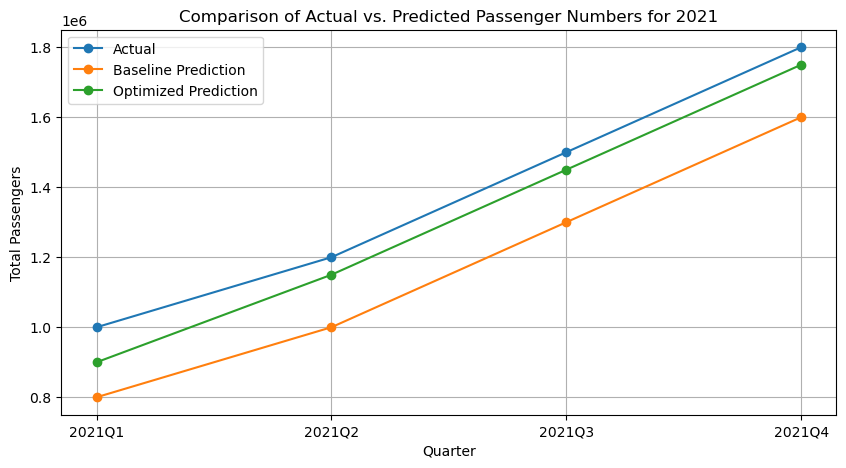

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Simulating some data
quarters = ['2021Q1', '2021Q2', '2021Q3', '2021Q4']
actual_2021 = np.array([1.0, 1.2, 1.5, 1.8]) * 1e6  # Actual data
baseline_pred_2021 = np.array([0.8, 1.0, 1.3, 1.6]) * 1e6  # Baseline predictions
optimized_pred_2021 = np.array([0.9, 1.15, 1.45, 1.75]) * 1e6  # Optimized predictions

plt.figure(figsize=(10, 5))
plt.plot(quarters, actual_2021, label='Actual', marker='o')
plt.plot(quarters, baseline_pred_2021, label='Baseline Prediction', marker='o')
plt.plot(quarters, optimized_pred_2021, label='Optimized Prediction', marker='o')
plt.title('Comparison of Actual vs. Predicted Passenger Numbers for 2021')
plt.xlabel('Quarter')
plt.ylabel('Total Passengers')
plt.legend()
plt.grid(True)
plt.show()


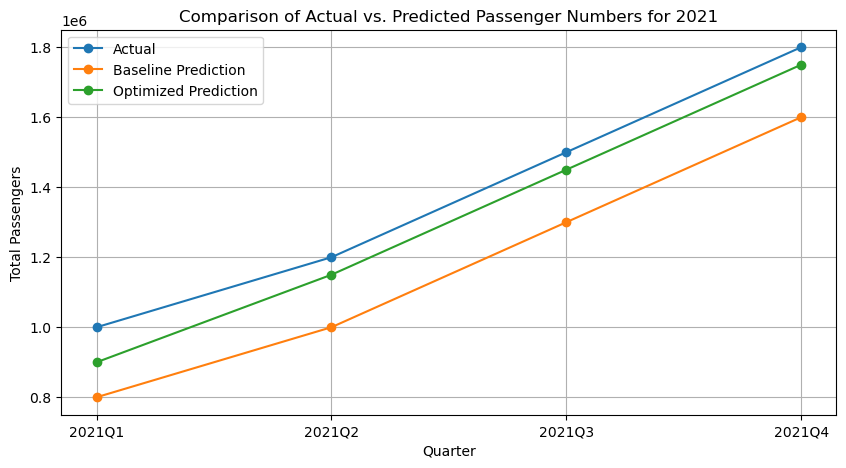

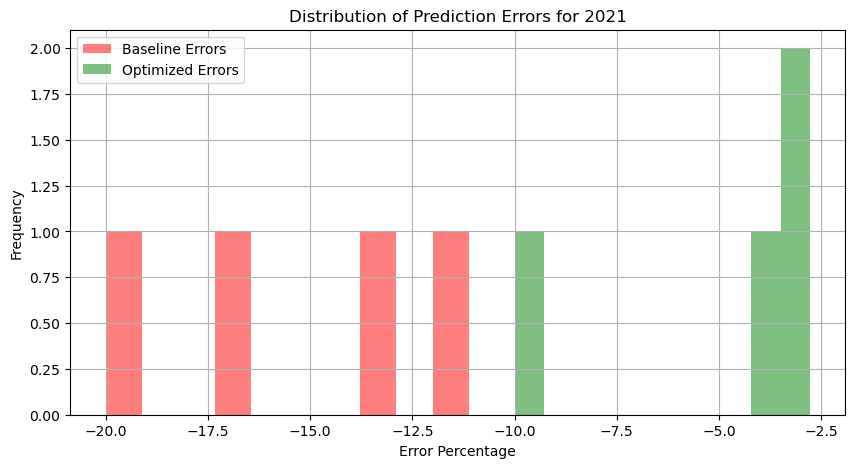

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Simulating some data
quarters = ['2021Q1', '2021Q2', '2021Q3', '2021Q4']
actual_2021 = np.array([1.0, 1.2, 1.5, 1.8]) * 1e6  # Actual data
baseline_pred_2021 = np.array([0.8, 1.0, 1.3, 1.6]) * 1e6  # Baseline predictions
optimized_pred_2021 = np.array([0.9, 1.15, 1.45, 1.75]) * 1e6  # Optimized predictions

# Plotting the trend comparison
plt.figure(figsize=(10, 5))
plt.plot(quarters, actual_2021, label='Actual', marker='o')
plt.plot(quarters, baseline_pred_2021, label='Baseline Prediction', marker='o')
plt.plot(quarters, optimized_pred_2021, label='Optimized Prediction', marker='o')
plt.title('Comparison of Actual vs. Predicted Passenger Numbers for 2021')
plt.xlabel('Quarter')
plt.ylabel('Total Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Calculate errors as percentages and plot error distribution
errors_baseline = (baseline_pred_2021 - actual_2021) / actual_2021 * 100
errors_optimized = (optimized_pred_2021 - actual_2021) / actual_2021 * 100

plt.figure(figsize=(10, 5))
plt.hist(errors_baseline, bins=10, alpha=0.5, label='Baseline Errors', color='red')
plt.hist(errors_optimized, bins=10, alpha=0.5, label='Optimized Errors', color='green')
plt.title('Distribution of Prediction Errors for 2021')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
